In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 12)

import sys
sys.path.insert(0, '../')

from dataloader.cityscapes import CityScapesDataset
from models.discriminator import SPADEDiscriminator
from models.spade import SPADE
from models.spade_resblk import SPADEResBlk
from models.generator import SPADEGenerator

## Step1: Get Data

In [2]:
path = '/home/kushaj/Desktop/Data/City Scape Dataset'
dataset = {
    x: CityScapesDataset(path, split=x, is_transform=True) for x in ['train', 'val']
}

data = {
    x: torch.utils.data.DataLoader(dataset[x], 
                  batch_size=4, 
                  shuffle=True, 
                  num_workers=4) for x in ['train', 'val']
}

Found 2975 train images
Found 500 val images


In [3]:
# Print images to see data is loading properly
iterator = iter(data['train'])
img, seg = next(iterator)
print(img.size())
print(seg.size())

torch.Size([4, 3, 128, 128])
torch.Size([4, 1, 128, 128])
WARN: resizing labels yielded fewer classes


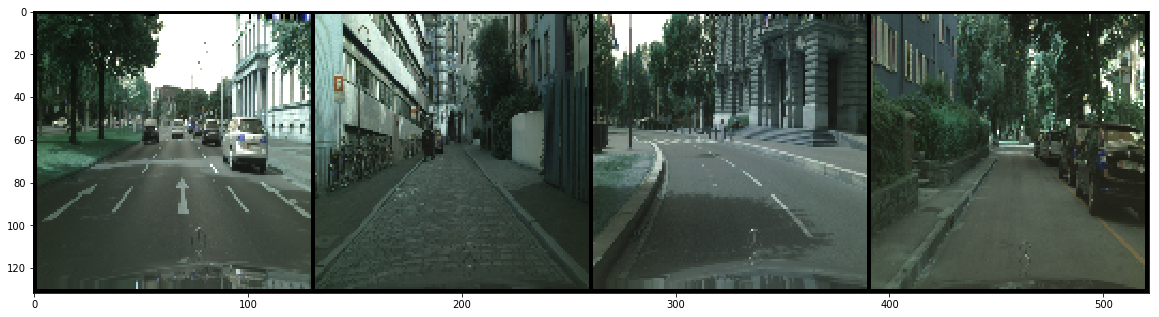

In [4]:
plt.rcParams['figure.figsize'] = (20, 12)
# Plotting functions for true image
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.pause(0.001)
    
grid_img = torchvision.utils.make_grid(img, nrow=4)
imshow(grid_img)

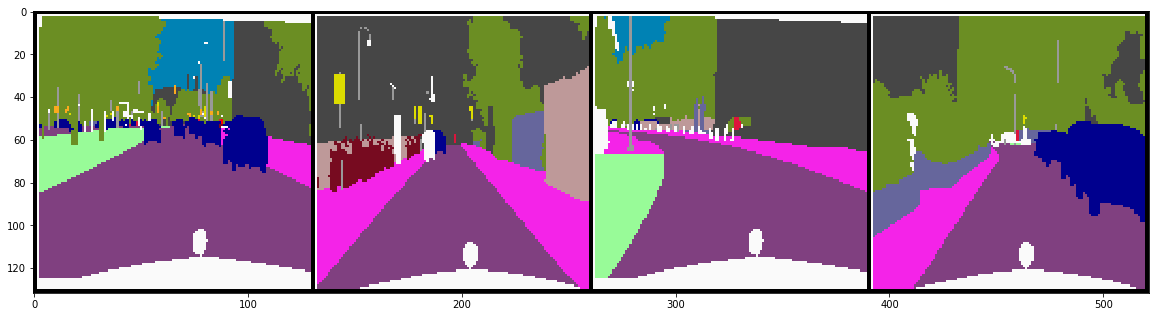

In [5]:
segmap = torch.zeros(seg.size(0), 3, seg.size(2), seg.size(3))
# Plotting function for segmentation task
for i, a in enumerate(seg):
    image = a.squeeze()
    image = image.numpy()
    image = dataset['train'].decode_segmap(image)
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image)
    segmap[i] = image
    
def imshow_seg(image):
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.pause(0.001)
    
grid_img = torchvision.utils.make_grid(segmap, nrow=4)
imshow_seg(grid_img)

## Step2: Create models

In [8]:
# Create class to resemble argparse
class Args:
    def __init__(self, spade_filter=128, spade_kernel=3, spade_resblk_kernel=3, gen_input_size=256, gen_hidden_size=16384):
        self.spade_filter = spade_filter
        self.spade_kernel = spade_kernel
        self.spade_resblk_kernel = spade_resblk_kernel
        self.gen_input_size = gen_input_size
        self.gen_hidden_size = gen_hidden_size
        
        if gen_hidden_size%16 != 0:
            print("Gen hidden size not multiple of 16")

spade_filter = 128
gen_input_size = 256
gen_hidden_size = 1024 * 16
args = Args(spade_filter, 3, 3, gen_input_size, gen_hidden_size)